# Load model

In [2]:
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
from training.dataset import Recordings30
from training.cnn_training_torch.CNN_model import CNNNetwork
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = 'saved_models/cnn_1.pt'
cnn = CNNNetwork()
cnn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [4]:
cnn.eval()

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=10880, out_features=30, bias=True)
)

# Prepare dataset

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 123
RECORDINGS_DIR = '/media/jacek/E753-A120/recordings_30/'
NOISES_DIR = '/path/to/noise/dataset'
SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 5
NUM_WORKERS = 8

/home/jacek/PycharmProjects/Bird-classification-model/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
df = filter_recordings_30("../../data/xeno_canto_recordings.csv", "../../data/bird-list-extended.csv", )

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2, random_state = SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5, random_state = SEED)

train_ds = Recordings30(train_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=SAMPLE_RATE, device = DEVICE)
val_ds = Recordings30(val_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate = 32000, device = DEVICE)
test_ds = Recordings30(test_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR,sample_rate = 32000,device = DEVICE)

train_dl  = DataLoader(train_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)
val_dl  = DataLoader(val_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)
test_dl  = DataLoader(test_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)

/home/jacek/PycharmProjects/Bird-classification-model/birdclassification/preprocessing/filtering.py:48: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv(filepath_recordings)


# Validation

In [7]:
from training.validation_metrics import calculate_metric
from sklearn.metrics import f1_score, precision_score
from training.validation_metrics import data_loader_accuracy, data_loader_balanced_accuracy, calculate_metric
from training.validation_metrics import get_classification_report, get_confusion_matrix
import numpy as np

In [8]:
train_ds.get_mapping()

{0: 'Alauda arvensis',
 1: 'Anas platyrhynchos',
 2: 'Apus apus',
 3: 'Asio otus',
 4: 'Buteo buteo',
 5: 'Carduelis carduelis',
 6: 'Ciconia ciconia',
 7: 'Columba livia',
 8: 'Corvus corax',
 9: 'Corvus cornix',
 10: 'Corvus frugilegus',
 11: 'Cuculus canorus',
 12: 'Cygnus olor',
 13: 'Dendrocopos major',
 14: 'Garrulus glandarius',
 15: 'Grus grus',
 16: 'Hirundo rustica',
 17: 'Lophophanes cristatus',
 18: 'Passer domesticus',
 19: 'Phalacrocorax carbo',
 20: 'Phasianus colchicus',
 21: 'Phoenicurus ochruros',
 22: 'Pica pica',
 23: 'Picus viridis',
 24: 'Sternula albifrons',
 25: 'Sturnus vulgaris',
 26: 'Tetrao urogallus',
 27: 'Turdus merula',
 28: 'Turdus torquatus',
 29: 'Turdus viscivorus'}

In [7]:
f1_score = calculate_metric(cnn, val_dl, metric=f1_score, average='macro')
f1_score

/home/jacek/PycharmProjects/Bird-classification-model/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0.6289532076871388

In [10]:
precision = calculate_metric(cnn, val_dl, metric=precision_score, average='macro')
precision

0.6966725769979618

In [9]:
get_classification_report(cnn, val_dl)

              precision    recall  f1-score   support

         0.0       0.73      0.87      0.80       265
         1.0       0.80      0.63      0.70       108
         2.0       0.85      0.73      0.79        71
         3.0       0.73      0.61      0.66       127
         4.0       0.59      0.67      0.63        94
         5.0       0.56      0.76      0.64       206
         6.0       0.64      0.50      0.56        14
         7.0       0.77      0.45      0.57        22
         8.0       0.55      0.88      0.68       207
         9.0       0.72      0.78      0.75       121
        10.0       0.62      0.69      0.65        70
        11.0       0.66      0.86      0.75       195
        12.0       0.45      0.27      0.34        52
        13.0       0.86      0.62      0.72       246
        14.0       0.57      0.59      0.58       188
        15.0       0.92      0.68      0.78        95
        16.0       0.75      0.56      0.64       166
        17.0       0.75    

In [9]:
confusion_matrix = get_confusion_matrix(cnn, val_dl)

Text(470.72222222222223, 0.5, 'Prediction')

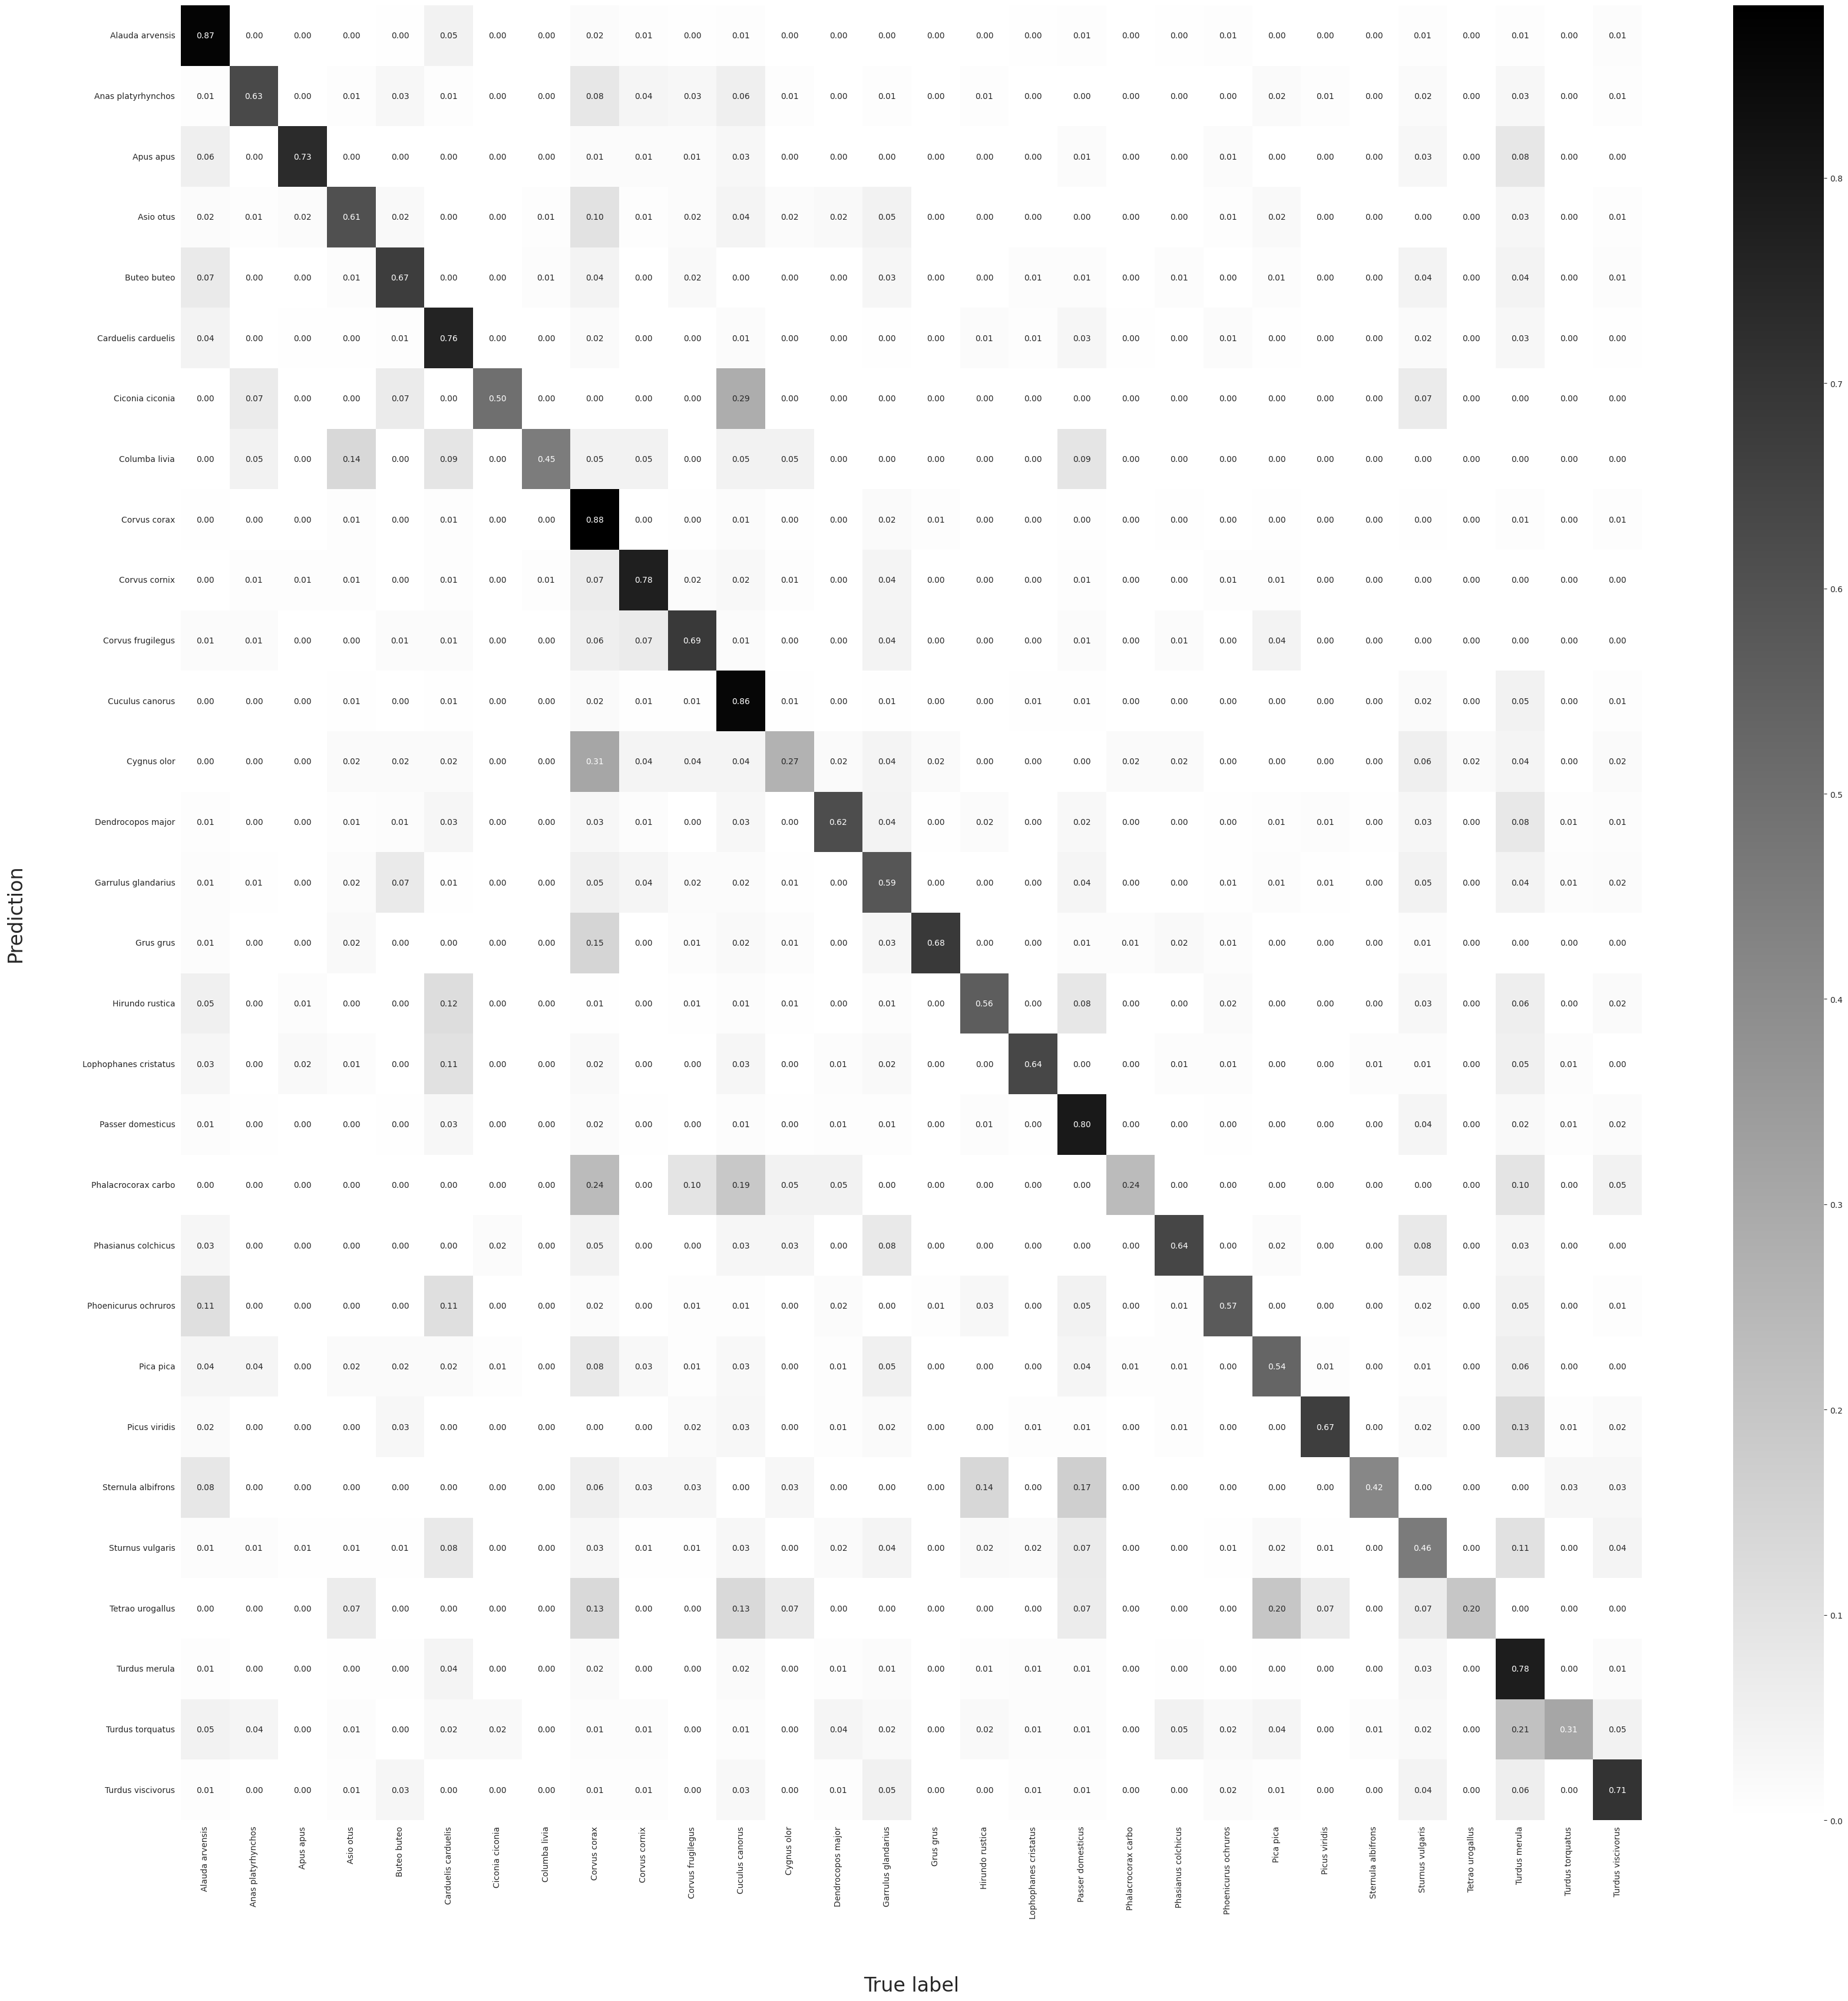

In [29]:
cm = confusion_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm)
df_cm.columns = train_ds.get_mapping().values()
df_cm.index = train_ds.get_mapping().values()
plt.figure(figsize = (40,40))
s = sns.heatmap(df_cm, annot=True, cmap = 'binary', fmt='.2f')
s.set_xlabel('True label', fontsize=24, labelpad=70)
s.set_ylabel('Prediction', fontsize=24, labelpad=70)
# s.set_title("Confusion matrix of predictions")